In [335]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Sampler
from collections import defaultdict
from collections import defaultdict
from torch.utils.data import Sampler
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.utils.data import Dataset
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

'''def generate_synthetic_data(batch_size, seq_len):
    x = np.linspace(0, 10, seq_len)
    phase_shifts = np.random.uniform(0, 2 * np.pi, size=batch_size)  # Random phase shift for each signal
    signals = np.array([np.sin(x + phase) + 0.1 * np.random.randn(seq_len) for phase in phase_shifts])
    return signals'''
def generate_synthetic_data(batch_size, seq_len):
    x = np.linspace(0, 10, 100)
    phase_shifts = np.random.uniform(0, 2 * np.pi, size=batch_size)  # Random phase shift for each signal
    label = []
    signals=[]
    for i in range(int(batch_size/2)):
        # Generate each signal as either sine or cosine based on a random choice
        signals.append(np.array([
            (np.sin(x + phase) ) + 0.1 * np.random.randn(1)
            for phase in phase_shifts
        ]))
        label.append(0)
    for i in range(int(batch_size/2)):
        # Generate each signal as either sine or cosine based on a random choice
        signals.append(np.array([
            ( np.cos(x + phase)) + 0.1 * np.random.randn(1)
            for phase in phase_shifts
        ]))
        label.append(1)
    return signals, label


# Mask part of the signal
def mask_signal_data(signal_data, mask_prob=0.15):
    mask = (torch.rand(signal_data.shape) < mask_prob)
    masked_signal_data = signal_data.clone()
    masked_signal_data[mask] = '[MASK]'  # Masking with zeros
    return masked_signal_data, mask

# Transformer model definition
class MaskedSignalModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_layers):
        super(MaskedSignalModel, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, input_dim)  # Final layer to predict the masked values
    
    def forward(self, src, src_mask):
        embedded_src = self.embedding(src)
        output = self.transformer_encoder(embedded_src)
        out = self.fc(output)
        return out, output



In [319]:
signal_data.shape

torch.Size([400, 100, 1])

In [375]:
import numpy as np
import pandas as pd

# Parameters
n_samples = 30  # Total number of samples
signal_length = 100  # Length of each time series
noise_level = 0.1  # Noise level

# Generate sine and cosine waves with noise
sine_signals = np.array([
    np.sin(np.linspace(0, 4 * np.pi, signal_length)) + noise_level * np.random.randn(signal_length)
    for _ in range(n_samples // 2)
])
cosine_signals = np.array([
    np.cos(np.linspace(0, 4 * np.pi, signal_length)) + noise_level * np.random.randn(signal_length)
    for _ in range(n_samples // 2)
])

# Concatenate sine and cosine signals and create output labels
signals = np.vstack([sine_signals, cosine_signals])
labels = np.array([0] * (n_samples // 2) + [1] * (n_samples // 2))  # 0 for sine, 1 for cosine


signals =(X_train[:400,:]) -40#-np.mean(X_train))/np.std(X_train)
labels = y_train[:400]
# Create a DataFrame for better readability
data = pd.DataFrame(signals)
data['label'] = labels

In [376]:

# Hyperparameters
batch_size, seq_len, input_dim = 32, 100, 1
model_dim = 16
num_layers = 2
epochs = 500

# Generate synthetic data
signal_data_np = data.iloc[:,:100].values#generate_synthetic_data(batch_size, seq_len)

signal_data = torch.tensor(signal_data_np, dtype=torch.float32).unsqueeze(-1)  # Add input_dim axis



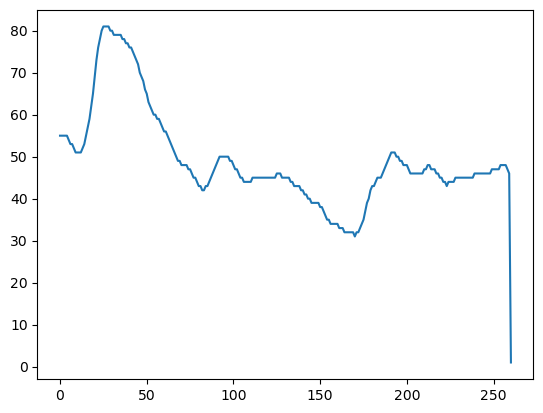

In [377]:
plt.plot(data.values[0,:])

In [378]:
def mask_chunks(signal, chunk_size, num_chunks):
    """
    Masks consecutive chunks of the input signal and returns both the masked signal
    and the mask indicating the positions that were masked.
    
    Parameters:
    - signal (torch.Tensor): Input signal of shape (batch_size, seq_len, 1).
    - chunk_size (int): Size of the consecutive chunks to mask.
    - num_chunks (int): Number of chunks to mask in each sequence.
    
    Returns:
    - masked_signal (torch.Tensor): Signal with chunks masked.
    - mask (torch.Tensor): Binary mask indicating masked positions (1 for masked, 0 for unmasked).
    """
    masked_signal = signal.clone()
    seq_len = signal.shape[1]
    mask = torch.zeros_like(signal)  # Initialize mask with all zeros (no masking)

    for i in range(signal.shape[0]):  # Loop through each sample in the batch
        for _ in range(num_chunks):
            # Randomly select a start index for the chunk
            start_idx = random.randint(0, seq_len - chunk_size)
            # Mask the chunk (set values to 0 or another token)
            masked_signal[i, start_idx:start_idx + chunk_size] = -1
            # Update the mask (set 1s for the masked chunk)
            mask[i, start_idx:start_idx + chunk_size] = True
    
    return masked_signal, mask



In [379]:
masked_signal_data, mask = mask_chunks(signal_data,15,1)



In [380]:
#masked_signal_data, mask = mask_signal_data(signal_data)

In [126]:
import random

In [166]:
batch_size

100

In [382]:
# Hyperparameters
batch_size, seq_len, input_dim = 32, 100, 1
model_dim = 16
num_layers = 2
epochs = 500

In [383]:
import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        # Create a long enough positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add a batch dimension
        pe = pe.unsqueeze(0) # shape: [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x is expected to have shape: [batch_size, seq_len, d_model]
        seq_len = x.size(1)
        # Add the positional encoding to the input embeddings
        x = x + self.pe[:, :seq_len, :]
        return x

class MaskedSignalModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_layers, max_len=5000):
        super(MaskedSignalModel, self).__init__()
        self.model_dim = model_dim
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim, max_len)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, input_dim)  # Final layer to predict masked values

    def forward(self, src, src_mask=None):
        # src: [batch_size, seq_len, input_dim]
        # First, embed the input features
        embedded_src = self.embedding(src)  # [batch_size, seq_len, model_dim]
        
        # Apply positional encoding
        embedded_src = self.pos_encoder(embedded_src) # [batch_size, seq_len, model_dim]

        # The transformer expects: [seq_len, batch_size, model_dim]
        embedded_src = embedded_src.transpose(0, 1)   # [seq_len, batch_size, model_dim]

        src_key_padding_mask = src_mask.squeeze(-1) 
        # Forward pass through Transformer encoder
        # If using key_padding_mask: shape is [batch_size, seq_len], so transpose accordingly
        output = self.transformer_encoder(embedded_src, src_key_padding_mask=src_key_padding_mask)

        
        # Back to [batch_size, seq_len, model_dim]
        output = output.transpose(0, 1)
        
        # Predict the masked values
        out = self.fc(output) # [batch_size, seq_len, input_dim]

        return out, output


In [384]:
masked_signal_data, mask = mask_chunks(signal_data,15,1)



In [385]:
masked_signal_data[0]

tensor([[55.],
        [55.],
        [55.],
        [55.],
        [55.],
        [54.],
        [53.],
        [53.],
        [52.],
        [51.],
        [51.],
        [51.],
        [51.],
        [52.],
        [53.],
        [55.],
        [57.],
        [59.],
        [62.],
        [65.],
        [69.],
        [73.],
        [76.],
        [78.],
        [80.],
        [81.],
        [81.],
        [81.],
        [81.],
        [80.],
        [80.],
        [79.],
        [79.],
        [79.],
        [79.],
        [79.],
        [78.],
        [78.],
        [77.],
        [77.],
        [76.],
        [76.],
        [75.],
        [74.],
        [73.],
        [72.],
        [70.],
        [69.],
        [68.],
        [66.],
        [65.],
        [63.],
        [62.],
        [61.],
        [60.],
        [60.],
        [59.],
        [59.],
        [58.],
        [57.],
        [56.],
        [56.],
        [55.],
        [54.],
        [53.],
        [52.],
        [5

In [427]:
# Mask part of the signal (15% masking)
#masked_signal_data, mask = mask_signal_data(signal_data)
masked_signal_data, mask = mask_chunks(signal_data,2,10)

# Target is the original signal
target = signal_data.clone()

batch_size=32
# Create a TensorDataset and DataLoader for batching
dataset = TensorDataset(masked_signal_data, mask, target)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



# Define the model, loss, and optimizer
model = MaskedSignalModel(input_dim=input_dim, model_dim=model_dim, num_layers=num_layers)
for name, param in model.named_parameters():
    if param.dim() > 1:
        nn.init.xavier_uniform_(param)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1)

epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    
    for batch in dataloader:
        batch_masked_signal, batch_mask, batch_target = batch
        
        # Forward pass
        output, emb = model(batch_masked_signal, batch_mask)
        
        # Compute loss (only for masked positions)
        loss = criterion(output[batch_mask.bool()], batch_target[batch_mask.bool()])


        epoch_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

# Plot the results for one example from the batch
example_idx = 0



Epoch 0/50, Loss: 180.00595092773438
Epoch 2/50, Loss: 320.7493591308594
Epoch 4/50, Loss: 352.0788879394531
Epoch 6/50, Loss: 377.8220520019531
Epoch 8/50, Loss: 335.6602478027344
Epoch 10/50, Loss: 469.46868896484375
Epoch 12/50, Loss: 399.704345703125
Epoch 14/50, Loss: 250.76748657226562
Epoch 16/50, Loss: 347.0931091308594
Epoch 18/50, Loss: 292.3110046386719
Epoch 20/50, Loss: 197.6037139892578
Epoch 22/50, Loss: 373.1650085449219
Epoch 24/50, Loss: 450.7012023925781
Epoch 26/50, Loss: 312.7904052734375
Epoch 28/50, Loss: 328.43377685546875
Epoch 30/50, Loss: 313.4592590332031
Epoch 32/50, Loss: 367.2237243652344
Epoch 34/50, Loss: 353.9764709472656
Epoch 36/50, Loss: 306.05682373046875
Epoch 38/50, Loss: 365.9536437988281
Epoch 40/50, Loss: 344.6813049316406
Epoch 42/50, Loss: 329.21185302734375
Epoch 44/50, Loss: 256.10791015625
Epoch 46/50, Loss: 245.1107635498047
Epoch 48/50, Loss: 344.7940673828125


In [433]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size=400
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    
    for batch in dataloader:
        batch_masked_signal, batch_mask, batch_target = batch
        
        # Forward pass
        output, emb = model(batch_masked_signal, batch_mask)
        
        # Compute loss (only for masked positions)
        loss = criterion(output[batch_mask.bool()], batch_target[batch_mask.bool()])
        epoch_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

# Plot the results for one example from the batch
example_idx = 0



Epoch 0/50, Loss: 271.0478820800781
Epoch 2/50, Loss: 178.5395050048828
Epoch 4/50, Loss: 196.26651000976562
Epoch 6/50, Loss: 184.3073272705078
Epoch 8/50, Loss: 288.4219055175781
Epoch 10/50, Loss: 267.0755920410156
Epoch 12/50, Loss: 324.5672607421875
Epoch 14/50, Loss: 354.2917175292969
Epoch 16/50, Loss: 348.52886962890625
Epoch 18/50, Loss: 167.76019287109375
Epoch 20/50, Loss: 355.68768310546875
Epoch 22/50, Loss: 262.42645263671875
Epoch 24/50, Loss: 357.8157653808594
Epoch 26/50, Loss: 249.7747039794922
Epoch 28/50, Loss: 165.94061279296875
Epoch 30/50, Loss: 184.36651611328125
Epoch 32/50, Loss: 237.04408264160156
Epoch 34/50, Loss: 270.79852294921875
Epoch 36/50, Loss: 205.4856719970703
Epoch 38/50, Loss: 117.56078338623047
Epoch 40/50, Loss: 309.9773254394531
Epoch 42/50, Loss: 234.10003662109375
Epoch 44/50, Loss: 321.3211669921875
Epoch 46/50, Loss: 252.32044982910156
Epoch 48/50, Loss: 184.50006103515625


In [432]:
batch_size

32

In [336]:
masked_signal_data, mask = mask_chunks(signal_data,30,1)



In [429]:
# Mask part of the signal (15% masking)
#masked_signal_data, mask = mask_signal_data(signal_data)
masked_signal_data, mask = mask_chunks(signal_data,5,3)


# Target is the original signal
target = signal_data.clone()

# Define the model, loss, and optimizer
model = MaskedSignalModel(input_dim=input_dim, model_dim=model_dim, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(50):
    model.train()
    
    # Forward pass
    output, emb = model(masked_signal_data, mask)
    
    # Compute loss (only for masked positions)
    loss = criterion(output[mask.int()], target[mask.int()])
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

# Plot the results for one example from the batch
example_idx = 0

Epoch 0/50, Loss: 3562.549560546875
Epoch 5/50, Loss: 3296.51708984375
Epoch 10/50, Loss: 3177.006591796875
Epoch 15/50, Loss: 3035.688720703125
Epoch 20/50, Loss: 2879.40869140625
Epoch 25/50, Loss: 2698.1669921875
Epoch 30/50, Loss: 2503.907470703125
Epoch 35/50, Loss: 2285.94091796875
Epoch 40/50, Loss: 2058.53125
Epoch 45/50, Loss: 1813.9566650390625


In [414]:
optimizer = optim.Adam(model.parameters(), lr=.0001)

# Training loop
for epoch in range(100):
    model.train()
    
    # Forward pass
    output, emb = model(masked_signal_data, mask)
    
    # Compute loss (only for masked positions)
    loss = criterion(output[mask.int()], target[mask.int()])
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

# Plot the results for one example from the batch
example_idx = 0



Epoch 0/50, Loss: 223.26187133789062
Epoch 5/50, Loss: 221.6829833984375
Epoch 10/50, Loss: 220.1232147216797
Epoch 15/50, Loss: 220.1674346923828


KeyboardInterrupt: 

In [400]:
output, emb = model(masked_signal_data, mask)
beds =emb

In [401]:
embeddings_np.reshape(100,-1).shape

(100, 6400)

In [402]:
embeddings_np = emb.detach().numpy()
embeddings_np=embeddings_np.reshape(400,-1)
embeddings_np = emb[:,:100,:].detach().numpy().reshape(400,-1)

In [403]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# For example, let's create synthetic embeddings of shape (batch_size, embedding_dim)
batch_size = 100
embedding_dim = 64

# Convert embeddings to numpy for PCA
#e#mbeddings_np = beds.detach().numpy()

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np)


In [404]:
DF_ALL = pd.DataFrame(embeddings_2d)
DF_ALL['label'] =labels

In [405]:
DF_ALL

,0,1,label
0,-0.158991,-1.310749,1
1,1.367209,1.254219,1
2,1.369065,-2.034657,1
3,0.387182,-2.481663,1
4,2.315795,2.522600,1
...,...,...,...
395,-1.243194,-3.996364,4
396,2.710097,0.722133,4
397,2.646372,2.132224,4
398,0.652645,-2.089290,4


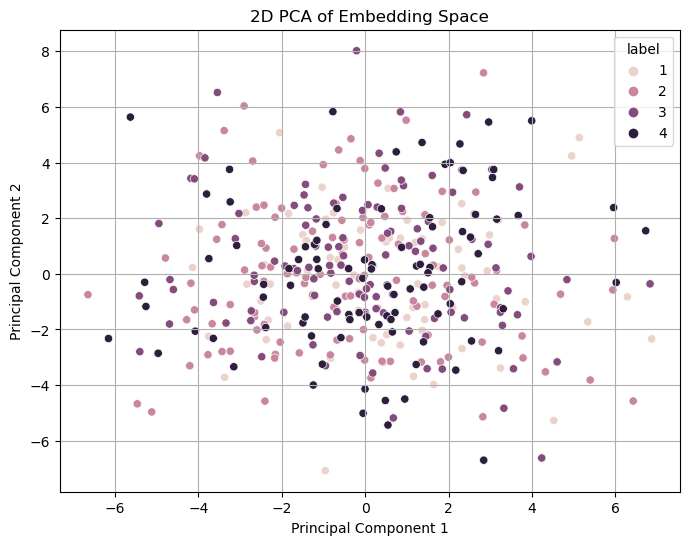

In [406]:

import seaborn as sns
# Plot the 2D PCA result
plt.figure(figsize=(8, 6))
sns.scatterplot(data = DF_ALL, x=0,y=1,hue = 'label')


plt.title("2D PCA of Embedding Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [409]:
example_idx = 1



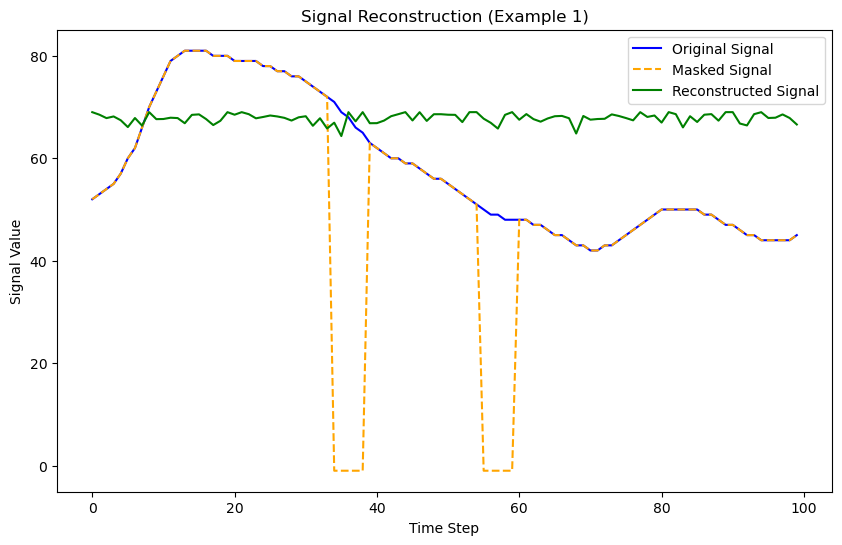

In [410]:
original_signal = signal_data[example_idx].squeeze().numpy()
masked_signal = masked_signal_data[example_idx].squeeze().numpy()
reconstructed_signal = output[example_idx].detach().squeeze().numpy()

# Plot original, masked, and reconstructed signals
plt.figure(figsize=(10, 6))
plt.plot(original_signal, label="Original Signal", linestyle='-', color='b')
plt.plot(masked_signal, label="Masked Signal", linestyle='--', color='orange')
plt.plot(reconstructed_signal, label="Reconstructed Signal", linestyle='-', color='g')
plt.legend()
plt.title(f"Signal Reconstruction (Example {example_idx})")
plt.xlabel("Time Step")
plt.ylabel("Signal Value")
plt.show()



# Real Data

In [24]:
import pickle
filename = 'processed_data/data.p'
with open(filename, 'rb') as file:
    (X, labels, pats, var_list) = pickle.load( file)
X_new=np.round(X,0)
X_new=X_new[:,:260].astype(int)
#X_new = (X_new-120)/20
type_ = 'real'
cutoff = int(len(pats)*.5)-23

X_train=X_new[:cutoff,:]
y_train=np.asarray(pats[:cutoff])
X_test= X_new[cutoff:,:]
y_test=np.asarray(pats[cutoff:])

labels_train = labels[:cutoff]
labels_test = labels[cutoff:]

In [27]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        """
        Args:
            data (Tensor): The input data.
            labels (Tensor): The corresponding labels or categories for the contrastive loss.
        """
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label



## Autoencoder
# Create a dataset and dataloader
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
  


class ProgressiveSameLabelBatchSampler(Sampler):
    def __init__(self, labels, batch_size):
        self.labels = labels
        self.batch_size = batch_size
        
        # Group indices by labels
        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)
        
        # Create a list of all labels
        self.labels_set = list(self.label_to_indices.keys())

    def __iter__(self):
        # Shuffle the labels
        labels_set = self.labels_set[:]
        random.shuffle(labels_set)

        batch = []
        while labels_set:
            # Randomly select and remove the first label
            current_label = labels_set.pop(0)
            indices = self.label_to_indices[current_label][:]
            random.shuffle(indices)
            
            while indices:
                # Add samples from the current label to the batch
                batch.append(indices.pop(0))

                # When the batch is full, yield it
                if len(batch) == self.batch_size:
                    yield batch
                    batch = []
                    
            # If the current label has no more samples and the batch is not full, pick the next label
            if not labels_set and len(batch) > 0:
                # If the batch is not empty and no more labels are left, yield the remaining batch
                yield batch
                batch = []

    def __len__(self):
        return len(self.labels) // self.batch_size

train_dataset = TimeSeriesDataset(torch.Tensor(X_train))
val_dataset = TimeSeriesDataset(torch.Tensor(X_test))
# Create dataset
dataset_train = CustomDataset(train_dataset, y_train)
dataset_val = CustomDataset(val_dataset, y_test, )





In [32]:
X_train.shape

(1649, 260)

In [39]:
y_train[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [140]:
emb.shape

torch.Size([32, 100, 64])

In [228]:
from huggingface_hub import hf_hub_download
import torch
from transformers import TimeSeriesTransformerForPrediction

file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

model = TimeSeriesTransformerForPrediction.from_pretrained(
    "huggingface/time-series-transformer-tourism-monthly"
)

# during training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

loss = outputs.loss
loss.backward()

# during inference, one only provides past values
# as well as possible additional features
# the model autoregressively generates future values
outputs = model.generate(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_time_features=batch["future_time_features"],
)

mean_prediction = outputs.sequences.mean(dim=1)

train-batch.pt:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

/var/folders/ys/xmkbmq116_j_q98mgk820pn40000gn/T/ipykernel_43288/2793130256.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch = torch.load(file)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/151k [00:00<?, ?B/s]